## The 3 most important facts about data scientists - a data informed approach

The **[Stack Overflow's Developer Survey](https://insights.stackoverflow.com/survey/2019)** is the largest survey where developers from all over the world answer questions about their jobs. I was curious if we could learn anything about the field of Data Science by taking a closer look at the responses.


### My main questions were:

1. [Which job titles are closest to the one of a `Data Scientist`?](#closest_job_titles)
- [What tools are most important for `Data Scientists`?](#tools)
- [Are `Data Scientists` happier in their jobs than other developers?](#happy)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import levene
from scipy.stats import ttest_ind

## Data preprocessing

From the raw file of reponses following preprocessing steps have been done:

```python
file_path = 'raw_data/survey_results_public.csv'

raw_df = pd.read_csv(file_path)

keep_cols = [
     "LanguageWorkedWith",
     "DatabaseWorkedWith",
     "PlatformWorkedWith",
     "WebFrameWorkedWith",
     "MiscTechWorkedWith",
     "JobSat",
     "DevType",
     ]

filtered_df = raw_df[keep_cols]

nan_devtype_pre = filtered_df["DevType"].isnull().sum()

# only keep rows where `DevType` is filled
filtered_df = filtered_df.dropna(axis="index", subset=["DevType"])
nan_devtype_after = filtered_df["DevType"].isnull().sum()
print(f"removed {nan_devtype_pre - nan_devtype_after} observations from analysis")

# Create column with flag when `DevType` contains `Data scientist or machine learning specialist`
filtered_df['is_data_scientist'] = filtered_df["DevType"].str.contains("Data scientist or machine learning specialist")

filtered_df.to_csv('raw_data/survey_results_public_data_scientists.csv', index=False)
```

In [2]:
# read stack overflow survey data from file
file_path = 'raw_data/survey_results_public_data_scientists.csv'

df = pd.read_csv(file_path)
df.head()

,LanguageWorkedWith,DatabaseWorkedWith,PlatformWorkedWith,WebFrameWorkedWith,MiscTechWorkedWith,JobSat,DevType,is_data_scientist
0,C++;HTML/CSS;Python,NaN,Windows,Django,NaN,NaN,"Developer, desktop or enterprise applications;...",False
1,HTML/CSS,PostgreSQL,NaN,NaN,NaN,Slightly satisfied,"Designer;Developer, back-end;Developer, front-...",False
2,C;C++;C#;Python;SQL,MySQL;SQLite,Linux;Windows,NaN,.NET,Slightly satisfied,"Developer, full-stack",False
3,C++;HTML/CSS;Java;JavaScript;Python;SQL;VBA,Couchbase;MongoDB;MySQL;Oracle;PostgreSQL;SQLite,Android;Linux;MacOS;Slack;Windows,Django;Express;Flask;jQuery;React.js;Spring,Cordova;Node.js,Slightly dissatisfied,"Academic researcher;Developer, desktop or ente...",False
4,Java;R;SQL,MongoDB;PostgreSQL,Android;Google Cloud Platform;Linux;Windows,NaN,Hadoop,Slightly satisfied,Data or business analyst;Data scientist or mac...,True


In [22]:
def split_str_to_list(df: pd.DataFrame, col: str, delimiter: str=';') -> pd.DataFrame:
    """
    Split string column to list using delimiter.
    
    Parameters
    ----------
    df: pd.DataFrame
        Dataframe to be processed
    col: string
        String column to split to list
    delimiter: string
        Delimiter of string column

    Returns
    -------
    pd.DataFrame
        Dataframe containing additional columns with lists prefixed by `list_`
    """
    list_col = "list_" + col
    df[list_col] = df[col].str.split(delimiter)
    return df

In [33]:
# columns containing multiple entries as strings
cols = [
    "DevType", 
    "LanguageWorkedWith",
    "DatabaseWorkedWith",
    "PlatformWorkedWith",
    "WebFrameWorkedWith",
    "MiscTechWorkedWith",
]

for col in cols:
    split_str_to_list(df=ds_df, col=col, delimiter=';')

In [3]:
# create dataframe with only `data scientists or machine learning specialists`
ds_df = df.query('is_data_scientist == True').copy()

# all respondents of survey
n = len(df) #81335
n_ds = len(ds_df)

print("How many individuals say they are `Data scientist or machine learning specialist`?\n")

print(
    f"Out of {n} respondents, {n_ds} say they are `Data scientist "
    f"or machine learning specialist`.\n"
    f"This is a share of {n_ds/n:.1%}"
    )

How many individuals say they are `Data scientist or machine learning specialist`?

Out of 81335 respondents, 6460 say they are `Data scientist or machine learning specialist`.
This is a share of 7.9%


<a id='closest_job_titles'></a>

# 1) Which job titles are closest to the one of a `Data Scientist`?

## Method:




In [32]:
def get_share_df(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Get shares of dataframe column.

    Parameters
    ----------
    df: pd.DataFrame
        Dataframe to be processed
    col: string
        Column to calculate share of total

    Returns
    -------
    pd.DataFrame
        Dataframe for plotting of shares
    """
    sample_cnt = len(df)
    
    tmp_df = df[col].apply(pd.Series).stack()
    share_df = tmp_df.value_counts().to_frame().rename(columns={0: "cnt"})
    share_df["share"] = share_df["cnt"] / sample_cnt
    share_df["metric"] = col
    share_df = share_df.reset_index().rename(columns={"index": "description"})
    
    return share_df

In [31]:
other_dev_types = get_share_df(df=ds_df, col="list_DevType").iloc[1:]
other_dev_types.head()

,description,cnt,share,metric
1,"Developer, back-end",3075,0.476006,list_DevType
2,"Developer, full-stack",2445,0.378483,list_DevType
3,Data or business analyst,2079,0.321827,list_DevType
4,Academic researcher,1874,0.290093,list_DevType
5,"Engineer, data",1872,0.289783,list_DevType


In [44]:
def plot_shares(x: str, y: str, title: str, color: str) -> None:
    """
    Plot shares as bar plot.
    
    Parameters
    ----------
    x: string
        `x` values to plot
    y: string
        `y` values to plot
    title: string
        Chart title
    color: string
        Color of chart

    Returns
    -------
    None
    """
    plot_args = {"x": x, "y": y, "color": color}
    
    ax = sns.barplot(**plot_args)
    ax.set_xticklabels(labels=plot_args["x"], rotation=90)
    vals = ax.get_yticks()
    ax.set_yticklabels(["{:,.0%}".format(y_val) for y_val in vals])
    ax.set_title(title)
    return None

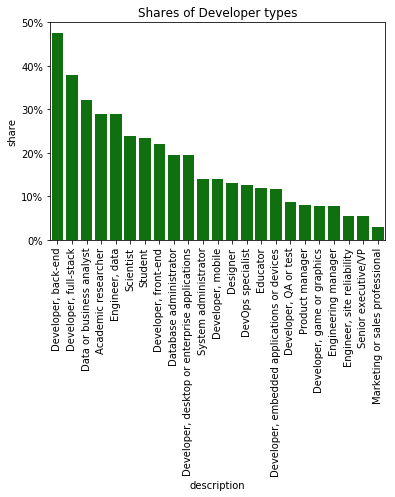

In [45]:
plot_shares(
    x=other_dev_types["description"], y=other_dev_types["share"], title="Shares of Developer types", color="g"
)

## Summary
Most developers stating that they are data scientists also say that they are **back-end Developers**. Second most say they are **full-stack developers**, and on position 3 **Data or business analysts** claim that they are Data Scientists.
Considering the high share of more then 7% of developers stating they are data scientists, it is questionable whether all respondents really spend the majority of their time with data scientist tasks. 
Nevertheless it gives some intuition that **back-end skills** and **full-stack skills** are very helpful to be effective as Data Scientist Practitioner. Data and business Analysts might on the other side be able to pick up deeper coding skills or work in cross-functional teems where they get help to put data science models into production.

<a id='tools'></a>

# What are the most important Frameworks, Libraries, and Tools data scientists use?

Let's dive deeper into which **frameworks, libraries, and tools** Data Scientists use accordingly to the Stackoverflow developers survey. In the following I will show the 10 most used languages Data Scientists worked with, the databases they used, and wich web-frameworks they are familiar with and which other Technologies they use.

In [46]:
metrics = [
    "list_LanguageWorkedWith",
    "list_DatabaseWorkedWith",
    "list_PlatformWorkedWith",
    "list_WebFrameWorkedWith",
    "list_MiscTechWorkedWith",
]

In [47]:
mydf = pd.DataFrame()

for metric in metrics:
    mydf = mydf.append(
        get_share_df(df=ds_df, col=metric), ignore_index=True
    )

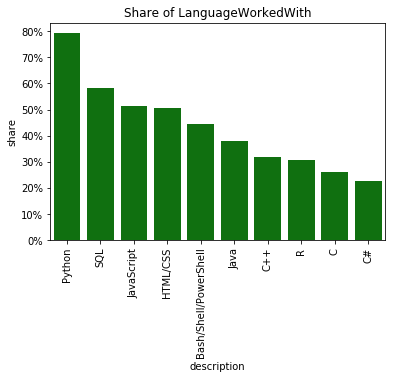

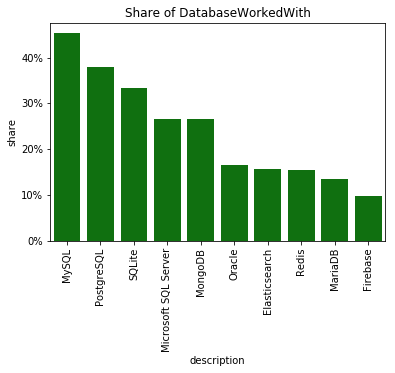

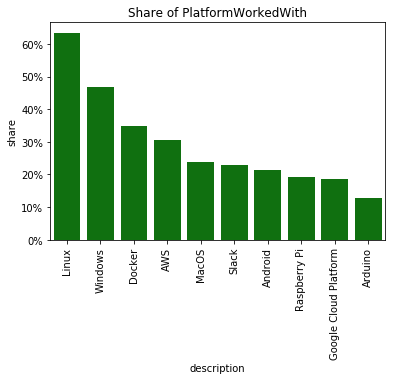

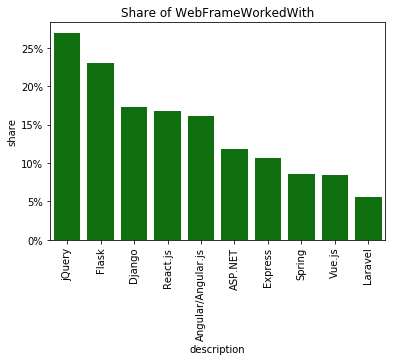

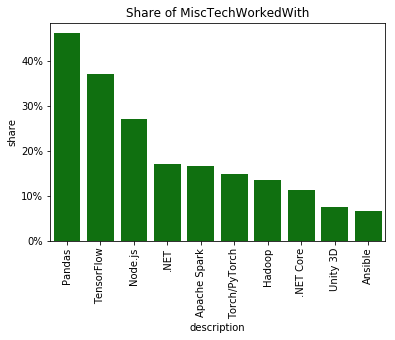

In [65]:
for metric in metrics:
    plot_shares(
        x=mydf.query("metric == @metric")["description"][:10],
        y=mydf.query("metric == @metric")["share"],
        title=f"Share of {metric.replace('list_', '')}",
        color="g",
    )
    plt.show()

<a id='happy'></a>

# Are data scientists happier with their job than others?

The last question to answer in this post is no matter how it is easiest to break into the field and no matter what tools they use - Is it acutally even worth the effort and are Data Scientists happier with their job than other developers?

In [17]:
# check encoding of `Job Satisfaction`
df["JobSat"].unique()

array([nan, 'Slightly satisfied', 'Slightly dissatisfied',
       'Neither satisfied nor dissatisfied', 'Very satisfied',
       'Very dissatisfied'], dtype=object)

In [18]:
# encode strings to numbers
job_satisfaction_mapping = {
    "Very dissatisfied": 0,
    "Slightly dissatisfied": 1,
    "Neither satisfied nor dissatisfied": 2,
    "Slightly satisfied": 3,
    "Very satisfied": 4,
}

In [19]:
# create column with mapping of strings to integers
df["JobSatNumeric"] = df["JobSat"].map(
    job_satisfaction_mapping, na_action="ignore"
)

In [20]:
# t_test_stats = df.groupby('is_data_scientist')['JobSatNumeric'].agg(['mean', 'std'])
# t_test_stats

In [21]:
# split data into reference and test set
ref_w_na = df.query("is_data_scientist == False")["JobSatNumeric"]
test_w_na = df.query("is_data_scientist == True")["JobSatNumeric"]

# remove `NaN`s
ref = ref_w_na.dropna()
test = test_w_na.dropna()

descriptive_stats = df.groupby("is_data_scientist")["JobSatNumeric"].agg(
    ["mean", "std"]
)

ref_mean = descriptive_stats.loc[False]["mean"]
ref_std = descriptive_stats.loc[False]["std"]
test_mean = descriptive_stats.loc[True]["mean"]
test_std = descriptive_stats.loc[False]["std"]

print("REFERENCE")
print("=========\n")
print(f"`NaN` values removed from analysis: {len(ref_w_na) - len(ref)}")

print(f"Number of observations: {len(ref)}")
print(f"Mean: {ref_mean:.2f}")
print(f"Standard deviation: {ref_std:.2f}")
print("\n")

print("TEST")
print("====\n")
print(f"`NaN` values removed from analysis: {len(test_w_na) - len(test)}")
print(f"Number of observations: {len(test)}")
print(f"Mean: {test_mean:.2f}")
print(f"Standard deviation: {test_std:.2f}")


REFERENCE

`NaN` values removed from analysis: 10546
Number of observations: 64329
Mean: 2.68
Standard deviation: 1.25


TEST
====

`NaN` values removed from analysis: 1083
Number of observations: 5377
Mean: 2.77
Standard deviation: 1.25


In [24]:
def plot_ab_test() -> None:
    """Plot distribution of A/B test."""
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    bins = np.arange(test.min() - 0.5, test.max() + 0.5)

    sns.distplot(
        ref,
        color="#0d696b",
        hist_kws={
            "histtype": "stepfilled",
            "linewidth": 3,
            "alpha": 0.8,
            "color": "#0d696b",
            "edgecolor": "#0d0000",
        },
        kde=False,
        ax=ax1,
        bins=bins,
    )

    sns.distplot(
        ref,
        color="#0d696b",
        hist=False,
        ax=ax2,
        kde_kws={"bw": 1},
        label="ref distribution",
    )
    ax1.axvline(ref_mean, color="#0d696b", linestyle="--", label="ref mean")

    sns.distplot(
        test,
        color="#f4b65c",
        hist_kws={
            "histtype": "stepfilled",
            "linewidth": 3,
            "alpha": 0.8,
            "color": "#f4b65c",
            "edgecolor": "#f49000",
        },
        kde=False,
        ax=ax1,
        bins=bins,
    )
    sns.distplot(
        test,
        color="#f4b65c",
        hist=False,
        ax=ax2,
        kde_kws={"bw": 1},
        label="test distribution",
    )
    ax1.axvline(test_mean, color="#f4b65c", linestyle="--", label="test mean")
    ax1.legend()
    ax1.set_title("Distribution of reference and test data", pad=20)
    ax1.set_ylabel("Count")
    ax1.set_ylabel("Count")
    ax2.set_ylabel("Density")
    plt.rcParams["patch.force_edgecolor"] = True

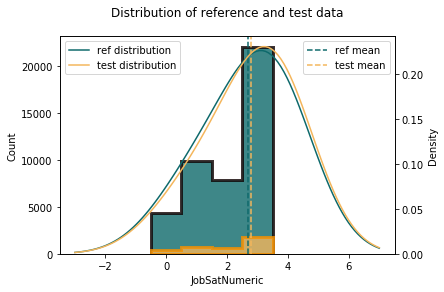

In [25]:
plot_ab_test()

In [27]:
# The Levene test tests the null hypothesis that all input samples are from
# populations with equal variances.
levene_statistic, levene_pvalue = levene(ref, test)
# test not significant, therefor equal variances can be assumed
print(f"levene statistic: {levene_statistic}, levene p-value: {levene_pvalue}")

statistic, two_sided_pvalue = ttest_ind(a=ref, b=test, axis=0, equal_var=True)
# half the p-value as t-test is performing a two-sided test and we have a
# one-sided hypothesis
one_sided_pvalue = two_sided_pvalue / 2

print(
    f"The test is significant on a confidence level of 95%\n"
    f"The p-value is: {one_sided_pvalue:.7f}"
)

levene statistic: 1.0668981200409065, levene p-value: 0.30165072324487513
The test is significant on a confidence level of 95%
The p-value is: 0.0000002
